### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 16 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1)mse : $$2 *(y - a)$$
2)exp : $$\exp(-a(x)y) * y $$
3)logloss : $$\frac{1}{1 + \exp(-a(x)y)} * (exp(-a(xi)y) * y)$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [28]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from random import sample
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [152]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', 
                 learning_rate=0.1, 
                 n_estimators=50, 
                 colsample=1.0, 
                 subsample=1.0, 
                 *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.losses_dict = {
            'mse' : self.mse_grad,
            'exploss' : self.exp_grad,
            'logloss' : self.logLoss_grad
        }
    

    def mse_grad(self, y_true, y_pred):
      return 2 * (y_true - y_pred)

    def exp_grad(self, y_true, y_pred):
      return np.exp(y_true * -y_pred) * y_true
      
   
    def logLoss_grad(self, y_true, y_pred):
      d1 = np.exp(-y_pred * y_true) 
      return (d1 * y_true) / (1 + d1)


    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
          
        loss_func = self.losses_dict[self.loss]
        obj_sample_size = int(np.round(self.subsample * X.shape[0]))
        cols_sample_size = int(np.round(self.colsample * X.shape[1]))

        self.models = []
        self.features = []

        if init_model is None:
          y_pred = 0
          self.startModel = None
        else:
          self.startModel = init_model()
          self.startModel.fit(X, y)
          y_pred = self.startModel.predict(X)

        for _ in range(self.n_estimators):
          estimator = base_model(*self.args, **self.kwargs)
          grad = loss_func(y, y_pred)
          x_train_size = np.array(sample(range(X.shape[0]), obj_sample_size))
          cols = np.array(sample(range(X.shape[1]), cols_sample_size))
          estimator.fit(X[x_train_size[:, np.newaxis], cols], grad[x_train_size])
          y_pred += self.learning_rate * estimator.predict(X[:, cols])
          self.models.append(estimator)
          self.features.append(cols)
        


        
    def predict(self, X):
      if self.startModel is None:
        y_pred = 0
      else:
        y_pred = self.startModel.predict(X)
      for model, feature in zip(self.models, self.features):
        y_pred += self.learning_rate * model.predict(X[:, feature])

      if self.loss == 'mse':       
            return np.around(y_pred).astype(int)
      else:
            return np.where(y_pred>=0, 1, -1)

In [153]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [154]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

my_clf.fit(X_train, y_train, base_model = DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))



1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [155]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [156]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [158]:
my_clf = MyGradientBoostingClassifier(n_estimators=2000)
my_clf.fit(X_train, y_train)



In [159]:
accuracy = []
y_pred = 0
for model, cols in zip(my_clf.models, my_clf.features):
        y_pred += my_clf.learning_rate * model.predict(X_test[:, cols])
        accuracy.append(accuracy_score(y_pred = np.round(y_pred).astype(int),
                                                        y_true=y_test))

In [160]:
import matplotlib.pyplot as plt


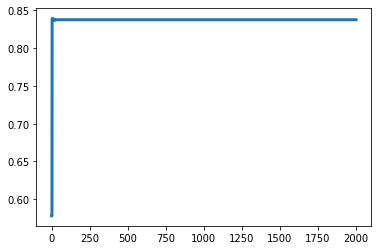

In [161]:
plt.plot(range(1, 2001), accuracy, linewidth = 3)

In [162]:
max(accuracy)

0.8393895348837209

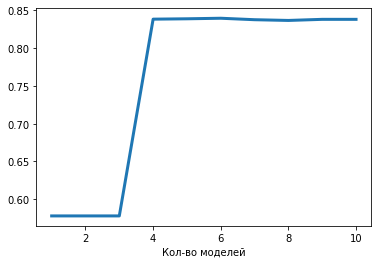

In [163]:
plt.xlabel("Кол-во моделей")
plt.plot(range(1, 11), accuracy[:10], linewidth = 3)
plt.show()



### Достаточно 4 моделей для максимальной точности.

In [164]:
# У нас y - [0, 1], сделаем [-1, 1]

In [165]:
class GridSearch:

  def __init__(self, losses, cols_sample, sub_samples):
    self.n_estimators =  15
    self.losses = losses
    self.cols_sample = cols_sample
    self.sub_samples = sub_samples
    self.max_accuracy = -1
  def findParams(self, X_train, y_train, X_test, y_test):
    logger = {'loss' : 'mse',
              'colsample' : 0,
              'subsample' :0,
              'n_estimators' : self.n_estimators}

    for loss in self.losses:
      for cols_s in self.cols_sample:
        for sub_s in self.sub_samples:
          my_clf = MyGradientBoostingClassifier(n_estimators=self.n_estimators, 
                                                loss = loss, colsample = cols_s,
                                                subsample = sub_s)
          if loss == 'mse':
            my_clf.fit(X_train, y_train)
            accuracy_pred = accuracy_score(my_clf.predict(X_test), y_test)
          else:
            my_clf.fit(X_train, 2 * y_train -1 ) #[0, 1] -> [-1, 1]
            accuracy_pred = accuracy_score(my_clf.predict(X_test), 2 * y_test -1)

          if accuracy_pred > self.max_accuracy:
            logger['loss'] = loss
            logger['colsample'] = cols_s
            logger['subsample'] = sub_s
            self.max_accuracy =  accuracy_pred
    return logger, self.max_accuracy


In [168]:
GsV = GridSearch(losses = ['logloss', 'mse', 'exploss'],
                 cols_sample = np.linspace(0.2, 1, 5),
                 sub_samples = np.linspace(0.2, 1, 5))

In [169]:
best_params, accuracy  = GsV.findParams(X_train, y_train, X_test ,y_test)

In [170]:
best_params

{'loss': 'logloss', 'colsample': 0.8, 'subsample': 0.8, 'n_estimators': 15}

In [171]:
accuracy

0.8943798449612403

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [172]:
my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, 2 * y_train - 1, base_model = RandomForestRegressor)

In [173]:
accuracy_score(my_clf.predict(X_test), 2 * y_test -1)

0.8955910852713178

In [174]:
N = 10

bagging = []

for i in range(N):
    objects = np.random.randint(0, X_train.shape[0], X_train.shape[0])
    my_clf = MyGradientBoostingClassifier(**best_params)
    my_clf.fit(X_train[objects, :], (y_train * 2 - 1)[objects])
    bagging.append(my_clf)



In [175]:
predicted = 0
for model in bagging:
  predicted += model.predict(X_test)

In [176]:
predicted = np.where(predicted >= 0, 1 ,-1)

In [177]:
accuracy_score(predicted, 2 * y_test -1)

0.8921996124031008

Данные методы не улучшили метрики. Для 1-го случая можно поиграться с гиперпараметрами RandomForest.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [178]:
base_models = [SVR, DecisionTreeRegressor, LinearRegression]

In [179]:
for model in base_models:
  my_clf = MyGradientBoostingClassifier(**best_params)
  my_clf.fit(X_train, y_train * 2 - 1, init_model=model)
  print(f"{model.__name__} : {accuracy_score(my_clf.predict(X_test), y_test * 2 - 1)}")


SVR : 0.7030038759689923
DecisionTreeRegressor : 0.8357558139534884
LinearRegression : 0.8873546511627907


##### SVR и DecisionTreeRegressor ухудшили результаты, однако если опять же менять и их гиперпараметры, то возможно это может улучшить метрики.

In [108]:


%%shell
jupyter nbconvert --to html /content/kirichenko_hw3.ipynb



[NbConvertApp] Converting notebook /content/kirichenko_hw3.ipynb to html
[NbConvertApp] Writing 353291 bytes to /content/kirichenko_hw3.html


## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

